<div class="alert alert-block alert-success">
    <b>ARTIFICIAL INTELLIGENCE (E016350)</b> <br>
ALEKSANDRA PIZURICA <br>
GHENT UNIVERSITY <br>
AY 2024/2025 <br>
Assistants: Xianlu Li and Nicolas Vercheval 
</div>

# Gaussian Mixture Models(GMM) versus K-Means clustering

In this tutorial, we will explore how Gaussian Mixture Models(GMM) perform soft clustering, how to turn it from soft to hard clustering and how this approach compares to K-Means.

In [23]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt

We will use the two datasets from the notebook Clustering Tutorial (see explanation in that notebook) and we will add another convex dataset but with elongated blobs:
- **Convex cluster**: `make_blobs` datasets: **X_blobs** and **X_elongate**. 
- **Non-Convex cluster**: `make_moons` dataset: **X_moons**.

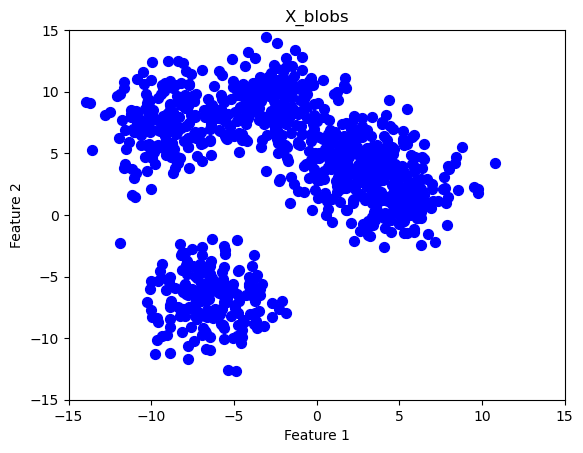

In [24]:
# Generate convex dataset (make_blobs)
from sklearn.datasets import make_blobs
X_blobs, y_blobs = make_blobs(n_samples=1000, centers=5, cluster_std=2.0, random_state=42)

# Visualize make_blobs dataset
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], color='b', s=50)

plt.title("X_blobs")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.show()


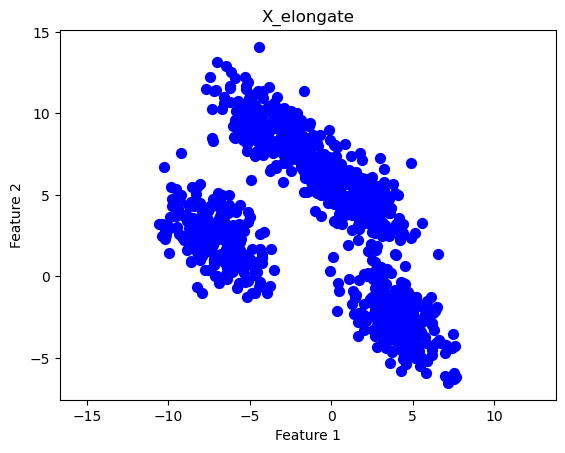

In [25]:
# Generate convex dataset (X_elongate)


X_elongate, _ = make_blobs(n_samples=1000, centers=4, cluster_std=2, random_state=42)
squeeze = np.array([[1,.5]])
rotate45 = np.array([[np.sqrt(2)/2, -np.sqrt(2)/2], [np.sqrt(2)/2, np.sqrt(2)/2]])
X_elongate = np.dot(X_elongate * squeeze, rotate45)
plt.scatter(X_elongate[:, 0], X_elongate[:, 1], color='b', s=50)

plt.title("X_elongate")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.axis('equal')
plt.show()

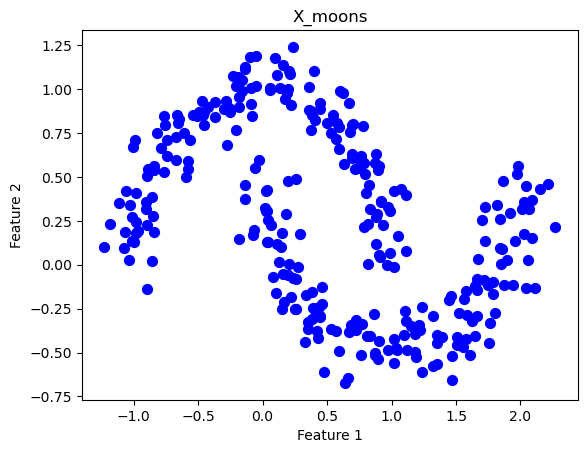

In [26]:
# Generate non-convex dataset (make_moons)
X_moons, y_moons = sklearn.datasets.make_moons(n_samples=300, noise=0.10, random_state=42)

# Visualize make_moons dataset
plt.scatter(X_moons[:, 0], X_moons[:, 1], color='b', s=50)
plt.title("X_moons")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


##  GMM (Gaussian Mixture Model)

The **Gaussian Mixture Model (GMM)** assumes that data points generated from a mixture of several Gaussian distributions with unknown parameters. GMM can be interpreted as a soft clustering method, meaning that each data point can belong to multiple clusters with different probabilities.

##### Important Hyperparameters
- **`covariance_type`**: The type of covariance to use for the Gaussian components. Common options are:
  - **`full`**: Each component has its own general covariance matrix.
  - **`tied`**: All components share the same covariance matrix.
  - **`diag`**: Each component has its own diagonal covariance matrix.
  - **`spherical`**: Each component has its own single variance value.

The choice of covariance type determines the flexibility of the cluster shapes, with `full` allowing ellipsoidal clusters and `spherical` limiting them to spheres.

## GMM VS K-Means
### Theoretical Comparison

- **Modeling Strategy**:
  - **K-Means**: Assumes data points form **spherical clusters**.
  - **GMM**: More flexible, deals well also with  **ellipsoidal shapes** of the clusters.

- **Hard vs. Soft Assignment**:
  - **K-Means**: Employs **hard assignment**, meaning each data point is exclusively assigned to one cluster, potentially distorting results when noise is present.
  - **GMM**: Uses **soft assignment**, where each data point is assigned a probability of belonging to a given cluster. This probabilistic approach helps GMM **handle noise more effectively**, reducing the influence of outliers by spreading their contribution across clusters. To turn the soft assignments into hard clustering the probabilities (if this is desired), each data point will be assigned to the cluster with the **highest probability value**. This process can be represented by the following equation:
    \begin{equation}
        \text{label}_i = \arg \max_k P(\text{cluster}_k | \text{data point}_i)
    \end{equation}

where $\text{label}_i$ is the label for data point $i$, and $p(\text{cluster}_k | \text{data point}_i)$ is the probability of data point $i$ belonging to cluster $k$. 


In [27]:
#clustering with visualise result
from matplotlib.patches import Ellipse, Circle
from scipy.spatial.distance import cdist
# Define the color list
colors = ['b', 'g', 'r', 'c', 'm',  'k', 'orange', 'y', 'purple', 'brown',
          'pink', 'gray', 'olive', 'cyan', 'magenta']

def plot_kmeans(kmeans, X, ax=None):
    labels = kmeans.fit_predict(X)
    ax = ax or plt.gca()
    ax.axis('equal')
    
    # Get the number of clusters and check if it exceeds the number of colors
    num_clusters = len(np.unique(labels))
    if num_clusters > len(colors):
        print("The number of clusters exceeds the number of available colors")
        return -1
    
    # Define the color mapping
    cluster_colors = colors[:num_clusters]
    color_map = np.array(cluster_colors)[labels]
    
    # Plot the data points
    ax.scatter(X[:, 0], X[:, 1], c=[colors[label] for label in labels], s=50, alpha=0.6)
    
    # Plot the centers and radii of the clusters
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    
    for i, (c, r) in enumerate(zip(centers, radii)):
        for rt in np.arange(r + 1):
            ax.add_patch(plt.Circle(
                c, rt, edgecolor=cluster_colors[i], facecolor='none', lw=2, alpha=0.2, zorder=1
            ))
        
    # Add legend
    for i in range(num_clusters):
        ax.scatter([], [], color=cluster_colors[i], label=f'Cluster {i}')
    ax.legend()
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title('KMeans Clustering')
    
def plot_gmm(gmm, X, label=True, ax=None, colors=None):
    ax = ax or plt.gca()
    ax.axis('equal')

    gmm.fit(X)
    labels = gmm.predict(X)
    num_clusters = gmm.n_components

    if colors is None:
        colors = ['b', 'g', 'r', 'c', 'm',  'k', 'orange', 'y', 'purple', 'brown',
          'pink', 'gray', 'olive', 'cyan', 'magenta']

    def draw_ellipse(position, covariance, ax, color, alpha=.5):
        if covariance.shape == (2, 2):
            U, s, Vt = np.linalg.svd(covariance)
            angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
            width, height = 2 * np.sqrt(s)
        elif covariance.shape == (2,) and covariance[0]!=covariance[1]:
            angle = 0
            width, height = 2 * np.sqrt(covariance)
        elif covariance.shape == (2,) and covariance[0]==covariance[1]:  # Adjusting for spherical covariance
            angle = 0
            width = height = 2 * np.sqrt(covariance[0])

        for nsig in range(1, 4):
            # if width==height:
            #     circle = Circle(xy=position, radius=width, color=color, alpha=0.5, fill=False)
            #     ax.add_patch(circle)
            # else:
            ellipse = Ellipse(xy=position, width=nsig * width, height=nsig * height,
                              angle=angle, color=color, alpha=alpha, fill=False)
            ax.add_patch(ellipse)

    w_factor = 0.2 / gmm.weights_.max()
    for i, pos in enumerate(gmm.means_):
        if gmm.covariance_type == 'tied':
            draw_ellipse(pos, gmm.covariances_, ax, color=colors[i])
        elif gmm.covariance_type == 'diag':
            draw_ellipse(pos, np.diag(gmm.covariances_[i]), ax, color=colors[i])
        elif gmm.covariance_type == 'spherical':
            draw_ellipse(pos, np.array([gmm.covariances_[i], gmm.covariances_[i]]), ax, color=colors[i])
        else:  # 'full'
            draw_ellipse(pos, gmm.covariances_[i], ax, color=colors[i])

    scatter = ax.scatter(X[:, 0], X[:, 1], c=[colors[label] for label in labels], s=50, alpha=0.6)

    if label:
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=f'Cluster {i}') for i in range(num_clusters)]
        ax.legend(handles=handles, title="Clusters")

    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title('Gaussian Mixture Model Clustering')

def plot_gmm_and_kmeans(kmeans_blob, kmeans_elongate, gmm_blobs, gmm_elongate, covariance_type='full'):
    
    # Create a 2x2 plotting area
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Plot KMeans results on X_blobs
    plot_kmeans(kmeans_blob, X_blobs, ax=axes[0, 0])
    axes[0, 0].set_title('K-Means on Blobs')
    
    # Plot GMM results on X_blobs
    plot_gmm(gmm_blobs, X_blobs, ax=axes[0, 1])
    axes[0, 1].set_title(f'GMM on Blobs with {covariance_type} covariance')
    
    # Plot KMeans results on X_elongate
    plot_kmeans(kmeans_elongate, X_elongate, ax=axes[1, 0])
    axes[1, 0].set_title('K-Means on Elongate')
    
    # Plot GMM results on X_elongate
    plot_gmm(gmm_elongate, X_elongate, ax=axes[1, 1])
    axes[1, 1].set_title(f'GMM on Elongate with {covariance_type} covariance')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Display the plots
    plt.show()

In [28]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

def compute_gmm(covariance_type='full'):
    # Initialize the models
    
    gmm_blobs = GaussianMixture(n_components=5, covariance_type=covariance_type, random_state=3)
    gmm_elongate = GaussianMixture(n_components=4, covariance_type=covariance_type, random_state=3)
    return gmm_blobs, gmm_elongate

### GMM vs K-Means visualised

To illustrate how K-Means works, we draw circles around the centroids that measure the distance of nearby points.
Since each point is assigned to the closest centroid according to the Euclidean distance, the circles are a good representation of the clusters' area of influence. 

To compare with K-Means, we show the hard assignments given by the GMM model, with different constraints on the covariance matrix.
We show each Gaussian component's distributions by looking at their contour plots.

#### GMM with different `covariance_type` versus Kmeans on convex data

#### Full covariance

Using the full covariance, the GMM model finds the correlation matrix that fits the data better for each component.

We see that both K-Means and the GMM model are good at clustering the Blobs dataset: K-Means correctly assumes that the clusters are spherical, while GMM recovers an almost isotropic (spherical) distribution.

On the other hand, the GMM model with full covariance can separate the elliptical clusters in the Elongate dataset much better than K-Means. 


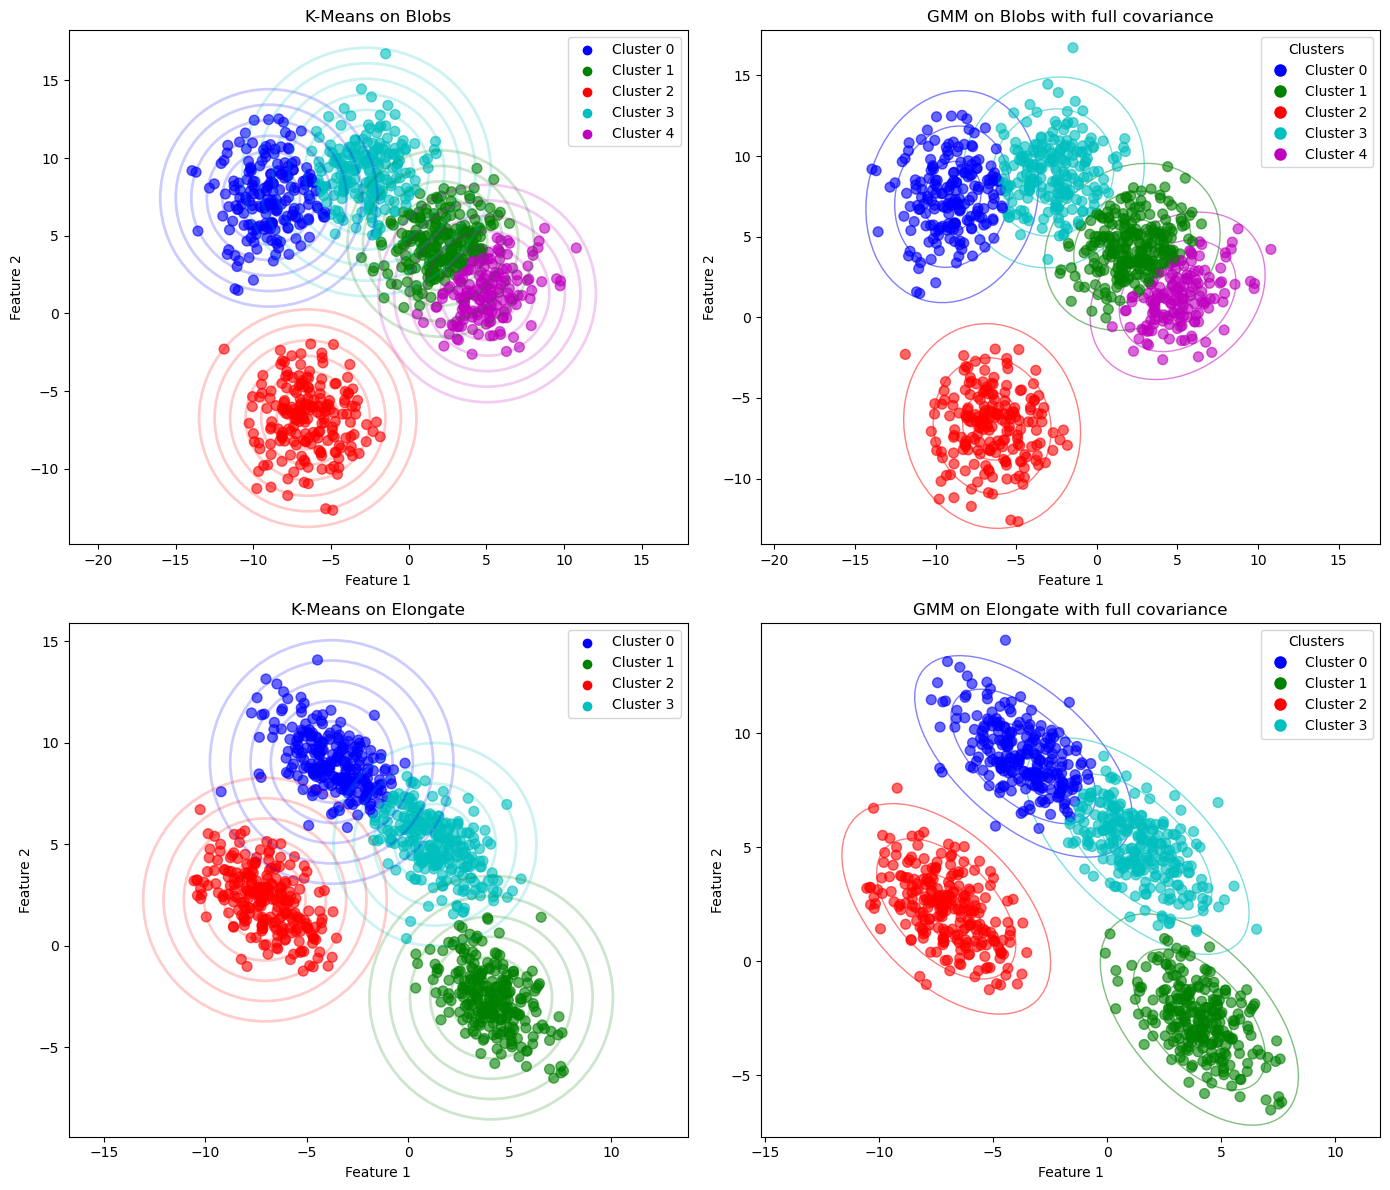

In [29]:
kmeans_blob = KMeans(n_clusters=5, random_state=3)
kmeans_elongate = KMeans(n_clusters=4, random_state=3)
gmm_blobs, gmm_elongate = compute_gmm()
plot_gmm_and_kmeans(kmeans_blob, kmeans_elongate, gmm_blobs, gmm_elongate)

### Tied covariance

Using the tied covariance, the GMM model finds a single correlation matrix that best fits all the components.

The model still performs very well in both the Elongated and Blobs datasets because they have clusters of the same shape.

In particular, we see that the contour in the Blobs dataset is more spherical than using the full covariance matrix, resulting as an average of the shapes that we got using the full covariance matrix.

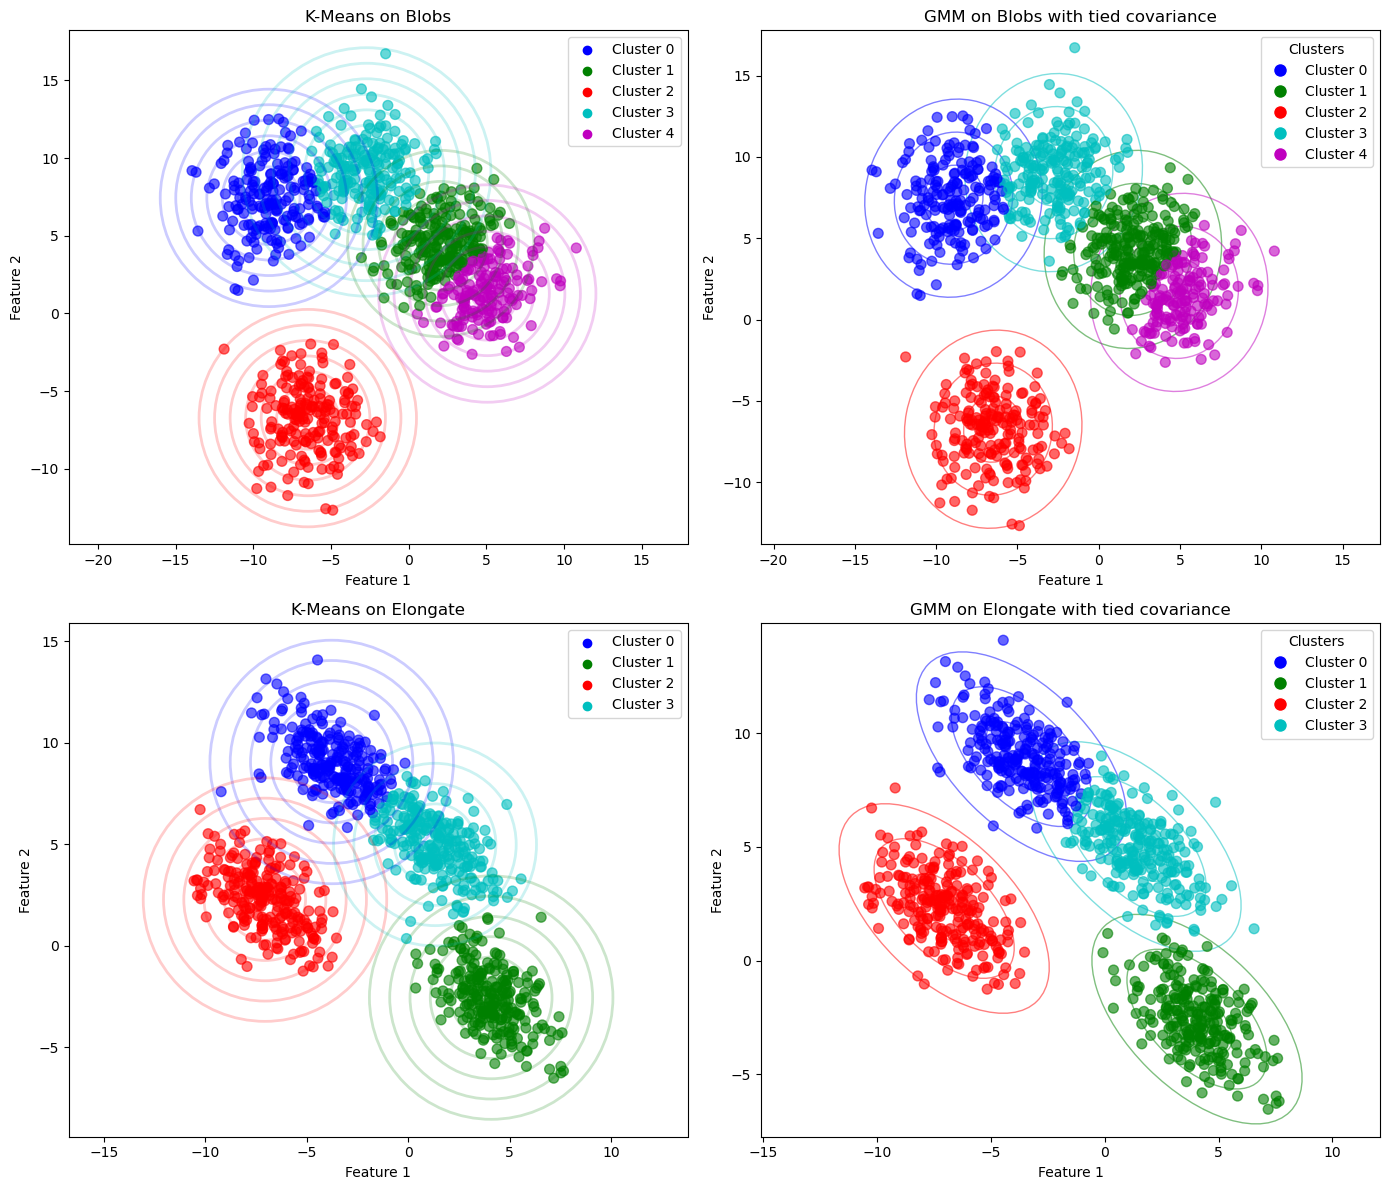

In [30]:
covariance_type = 'tied'
gmm_blobs, gmm_elongate = compute_gmm(covariance_type)
plot_gmm_and_kmeans(kmeans_blob, kmeans_elongate, gmm_blobs, gmm_elongate, covariance_type=covariance_type)


### Diag covariance

Using the diagonal covariance, the GMM model assumes that the features are independent. 

This is true in the Blobs dataset, which is correctly clustered, but not in the elongated dataset.

In particular, we see that, in the elongated dataset, the contour plots are not as tight around the clusters and a few points are assigned to the wrong cluster. 

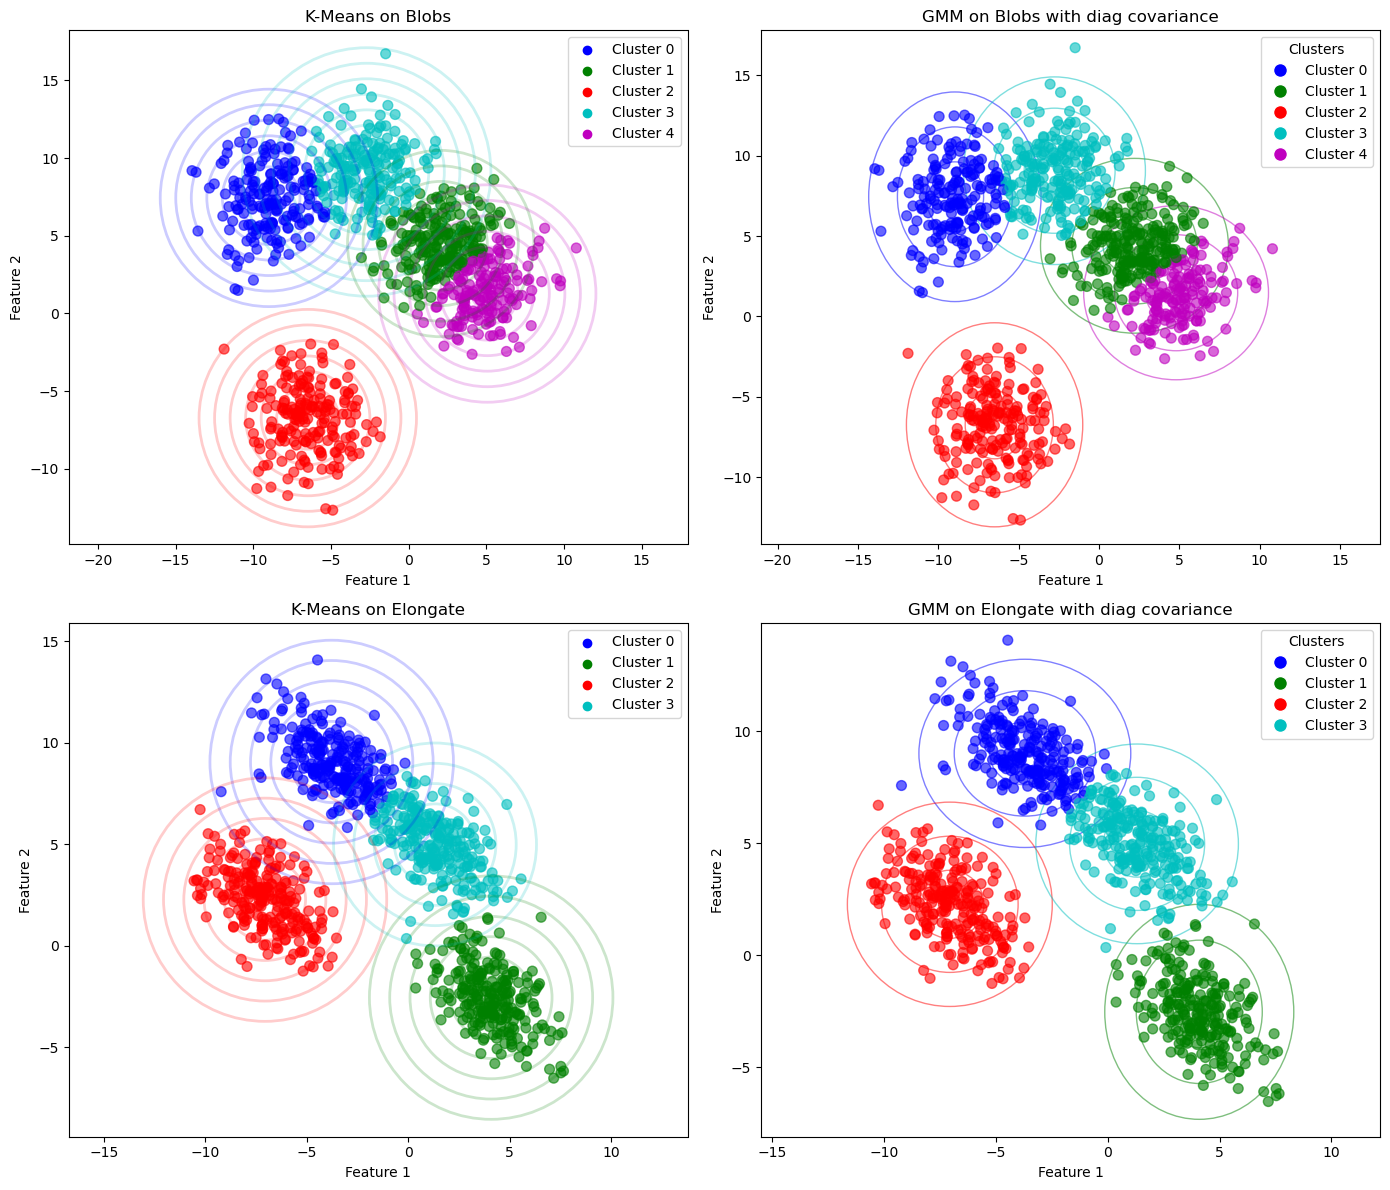

In [31]:
covariance_type = 'diag'
gmm_blobs, gmm_elongate = compute_gmm(covariance_type)
plot_gmm_and_kmeans(kmeans_blob, kmeans_elongate, gmm_blobs, gmm_elongate, covariance_type=covariance_type)

### Spherical covariance

Using the spherical covariance, the GMM model makes a similar assumption on the data of the K-Means algorithm. 

We can see that by comparing the K-Means spherical influence with the GMM contour plots.  

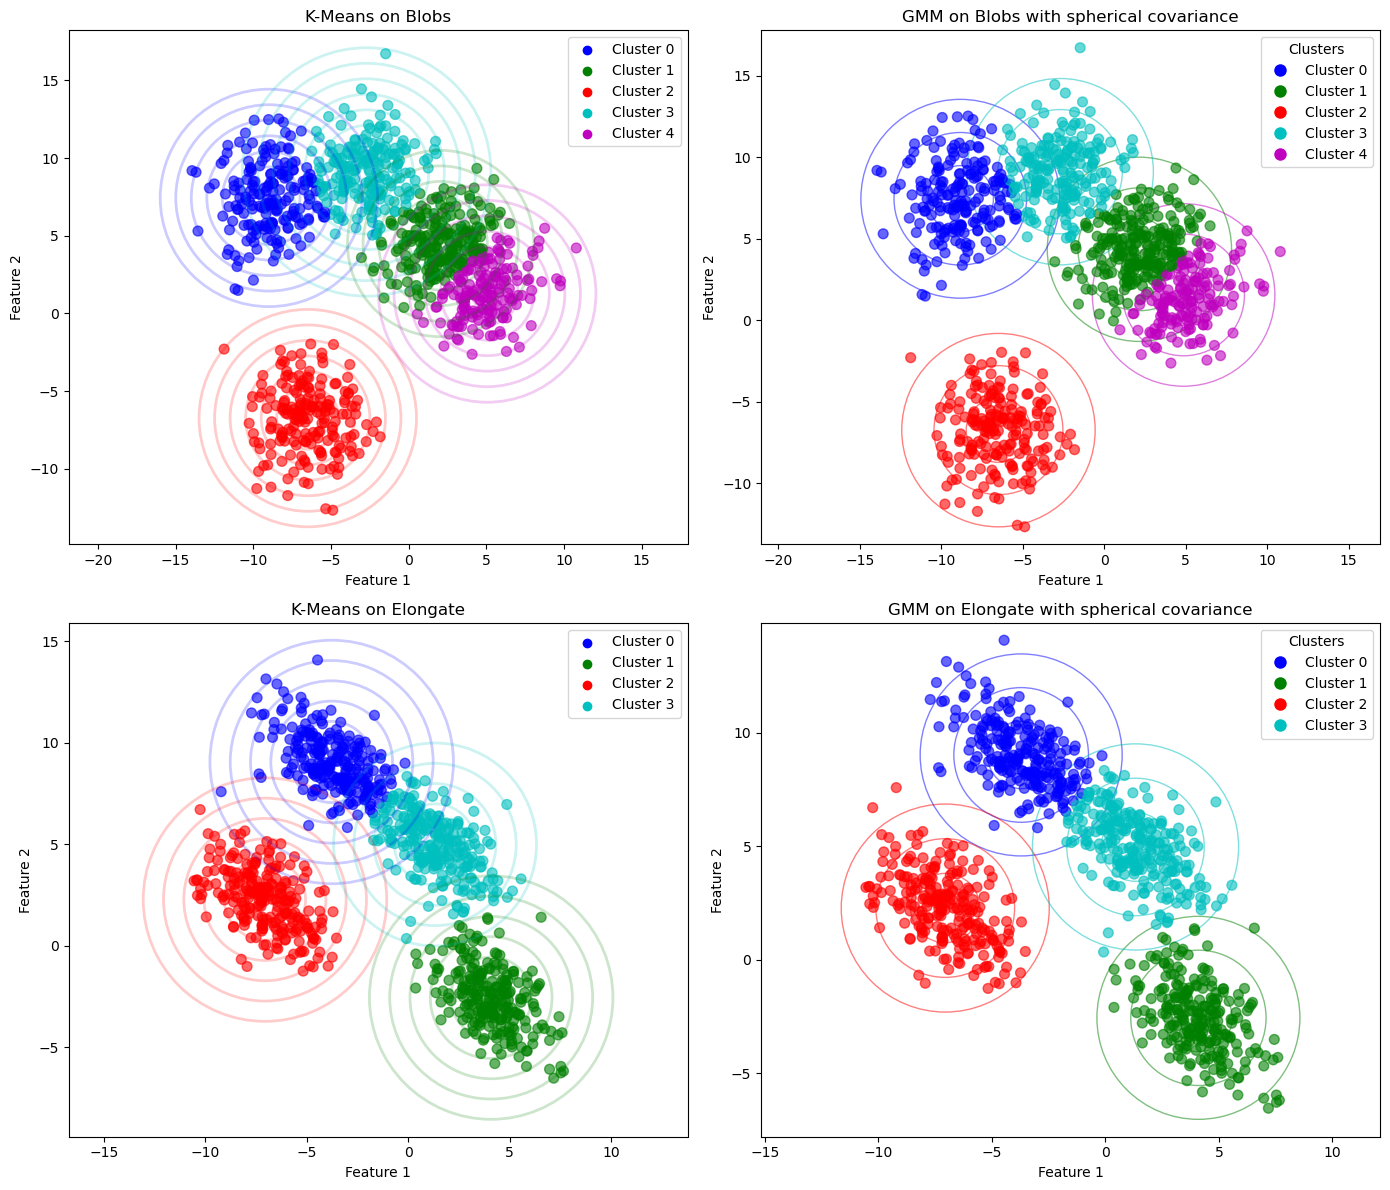

In [32]:
covariance_type = 'spherical'
gmm_blobs, gmm_elongate = compute_gmm(covariance_type)
plot_gmm_and_kmeans(kmeans_blob, kmeans_elongate, gmm_blobs, gmm_elongate, covariance_type=covariance_type)

#### GMM versus K-Means on Non-convex clusters

For the Moons Dataset, both methods faced challenges in accurately clustering the data, as their underlying modelling assumptions are ill-suited for non-convex shapes such as those found in the moons.

We only show the results for the full covariance GMM.

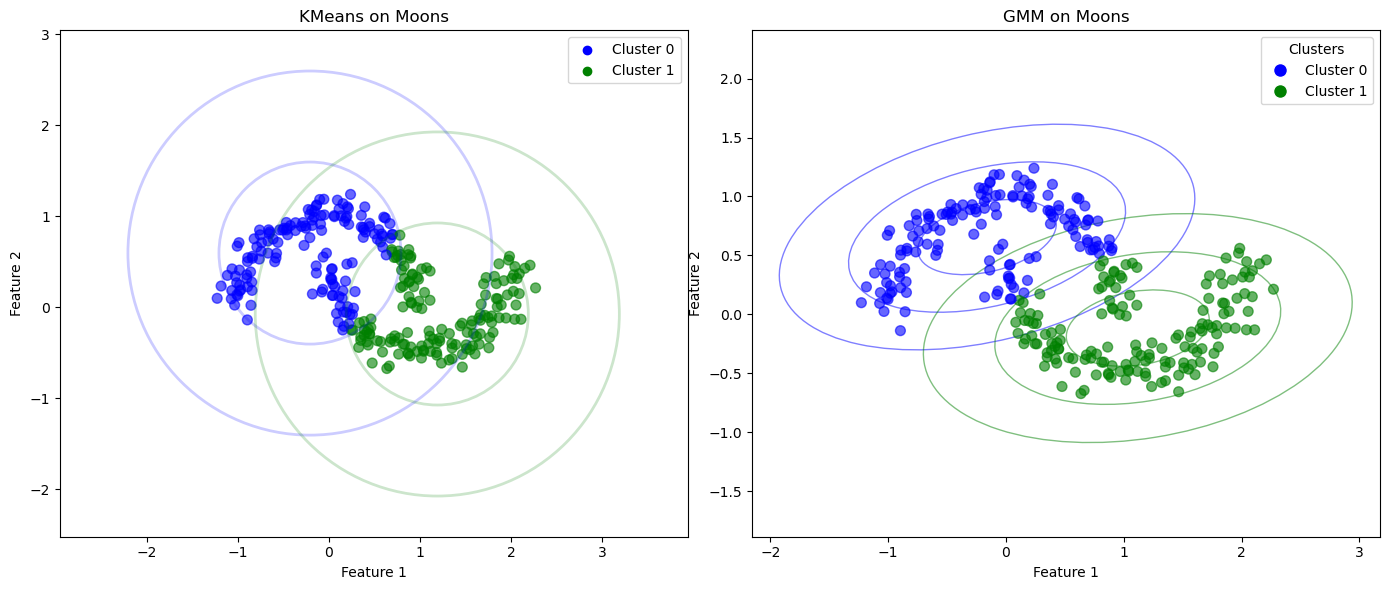

In [33]:
# Initialize the models
kmeans_moon = KMeans(n_clusters=2, random_state=42)
gmm_moon = GaussianMixture(n_components=2, covariance_type='full', random_state=42)

# Create a 1x2 plotting area
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjusted subplot dimensions and figsize

# Plot KMeans results on X_moons
plot_kmeans(kmeans_moon, X_moons, ax=axes[0])  # Corrected axes indexing
axes[0].set_title('KMeans on Moons')

# Plot GMM results on X_moons
plot_gmm(gmm_moon, X_moons, ax=axes[1])  # Corrected axes indexing
axes[1].set_title('GMM on Moons')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()
